# Baiscs

In [1]:
import json
import os
import glob
import random
import re

from tqdm import tqdm
import pandas as pd
import numpy as np

from collections import Counter

import matplotlib.pyplot as plt

import datetime
import calendar

import seaborn as sns

# Self-defined Functions

In [3]:
%load_ext autoreload
%autoreload 2
#
import sys
sys.path.append('../')
from myutils.read_save import *
from myutils.tools import *
from settings.paths import *
from myutils.visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
####
# path
# path_data = my_path().stocktwits
# path_data2 = my_path().stocktwits2
# path_input = os.path.abspath(os.path.join(
#     my_path().parent,
#     'Input'
# ))
path_input = '\GME Short Squeeze Study\Input'
path_output = '\GME Short Squeeze Study\Output'
# path_input = os.path.abspath(os.path.join(
#     my_path().parent,
#     'Output'
# ))

---  
---  
---  


# Input Data  

## `df_input`

In [7]:
# df_input = read_input()
fname = os.path.join(path_input, 'tickerList500.csv')
df_input = pd.read_csv(
    fname, 
    encoding = 'utf-8',
    names = ['ticker', 'company', 'exchange', 'market_cap']
)

In [8]:
df_input.shape

(500, 4)

In [9]:
df_input.head()

,ticker,company,exchange,market_cap
0,MSFT,Microsoft Corporation,NASDAQ,7.792130e+11
1,AAPL,Apple Inc,NASDAQ,7.442210e+11
2,AMZN,Amazoncom Inc,NASDAQ,7.143000e+11
3,GOOGL,Alphabet Inc,NASDAQ,7.118650e+11
4,GOOG,Alphabet Inc,NASDAQ,7.020100e+11


## `df_price`: Price

In [10]:
folder = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'Data',
    'stocktwits',
    'price'
))
fname = os.path.join(folder, 'SP500_financial_data_pivot.csv')
df_price = pd.read_csv(
    fname,
    encoding = 'utf-8'
)

In [11]:
df_price.shape

(156576, 18)

In [12]:
df_price.head()

,ticker,date,prc,vol,ret,cap,ret_roll_avg_21d,prc_roll_avg_21d,vol_roll_avg_21d,ret_lag_1,ret_lag_2,ret_lag_3,prc_lag_1,prc_lag_2,prc_lag_3,vol_lag_1,vol_lag_2,vol_lag_3
0,A,2020-06-29,87.29,1302474.0,0.018277,2.695318e+10,-0.000231,88.442857,1.692013e+06,-0.015586,0.008087,-0.030466,85.90,87.26,86.56,2225790.0,1350229.0,1806600.0
1,A,2020-06-30,88.37,1920184.0,0.012373,2.728666e+10,-0.000599,88.369524,1.665249e+06,0.018277,-0.015586,0.008087,87.29,85.90,87.26,1302474.0,2225790.0,1350229.0
2,A,2020-07-01,88.11,1136989.0,-0.002942,2.720638e+10,-0.000940,88.265714,1.639251e+06,0.012373,0.018277,-0.015586,88.37,87.29,85.90,1920184.0,1302474.0,2225790.0
3,A,2020-07-02,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
4,A,2020-07-06,89.31,1412249.0,0.007104,2.757691e+10,-0.000741,88.092381,1.606384e+06,0.006469,-0.002942,0.012373,88.68,88.11,88.37,1507700.0,1136989.0,1920184.0


In [13]:
df_price['ticker'].nunique()

466

In [14]:
df_price['date'].nunique()

336

In [15]:
df_price['date'].min()

'2020-06-29'

In [16]:
df_price['date'].max()

'2021-10-26'

### 处理price空缺值

In [17]:
df_price['date'] = pd.to_datetime(df_price['date'])

In [18]:
full_date_range = pd.date_range(start='2020-06-29', end='2021-10-26')

In [19]:
# 对每个股票，生成完整的日期数据
df_price_full = df_price.set_index('date').groupby('ticker').apply(
    lambda x: x.reindex(full_date_range, method='ffill')
).reset_index(level=0, drop=True)

In [20]:
df_price_full

,ticker,prc,vol,ret,cap,ret_roll_avg_21d,prc_roll_avg_21d,vol_roll_avg_21d,ret_lag_1,ret_lag_2,ret_lag_3,prc_lag_1,prc_lag_2,prc_lag_3,vol_lag_1,vol_lag_2,vol_lag_3
2020-06-29,A,87.29,1302474.0,0.018277,2.695318e+10,-0.000231,88.442857,1.692013e+06,-0.015586,0.008087,-0.030466,85.90,87.26,86.56,2225790.0,1350229.0,1806600.0
2020-06-30,A,88.37,1920184.0,0.012373,2.728666e+10,-0.000599,88.369524,1.665249e+06,0.018277,-0.015586,0.008087,87.29,85.90,87.26,1302474.0,2225790.0,1350229.0
2020-07-01,A,88.11,1136989.0,-0.002942,2.720638e+10,-0.000940,88.265714,1.639251e+06,0.012373,0.018277,-0.015586,88.37,87.29,85.90,1920184.0,1302474.0,2225790.0
2020-07-02,A,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
2020-07-03,A,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,ZTS,208.51,1104379.0,-0.000527,9.865147e+10,0.000956,199.472381,1.386384e+06,0.011197,0.009147,0.008435,208.62,206.31,204.44,956999.0,794843.0,813720.0
2021-10-23,ZTS,208.51,1104379.0,-0.000527,9.865147e+10,0.000956,199.472381,1.386384e+06,0.011197,0.009147,0.008435,208.62,206.31,204.44,956999.0,794843.0,813720.0
2021-10-24,ZTS,208.51,1104379.0,-0.000527,9.865147e+10,0.000956,199.472381,1.386384e+06,0.011197,0.009147,0.008435,208.62,206.31,204.44,956999.0,794843.0,813720.0
2021-10-25,ZTS,211.52,1224710.0,0.014436,1.000756e+11,0.001639,199.795714,1.391753e+06,-0.000527,0.011197,0.009147,208.51,208.62,206.31,1104379.0,956999.0,794843.0


In [21]:
df_price_full = df_price_full.reset_index().rename(columns={'index':'date'})

In [22]:
df_price_full[:10]

,date,ticker,prc,vol,ret,cap,ret_roll_avg_21d,prc_roll_avg_21d,vol_roll_avg_21d,ret_lag_1,ret_lag_2,ret_lag_3,prc_lag_1,prc_lag_2,prc_lag_3,vol_lag_1,vol_lag_2,vol_lag_3
0,2020-06-29,A,87.29,1302474.0,0.018277,2.695318e+10,-0.000231,88.442857,1.692013e+06,-0.015586,0.008087,-0.030466,85.90,87.26,86.56,2225790.0,1350229.0,1806600.0
1,2020-06-30,A,88.37,1920184.0,0.012373,2.728666e+10,-0.000599,88.369524,1.665249e+06,0.018277,-0.015586,0.008087,87.29,85.90,87.26,1302474.0,2225790.0,1350229.0
2,2020-07-01,A,88.11,1136989.0,-0.002942,2.720638e+10,-0.000940,88.265714,1.639251e+06,0.012373,0.018277,-0.015586,88.37,87.29,85.90,1920184.0,1302474.0,2225790.0
3,2020-07-02,A,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
4,2020-07-03,A,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
5,2020-07-04,A,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
6,2020-07-05,A,88.68,1507700.0,0.006469,2.738238e+10,-0.000737,88.179524,1.645204e+06,-0.002942,0.012373,0.018277,88.11,88.37,87.29,1136989.0,1920184.0,1302474.0
7,2020-07-06,A,89.31,1412249.0,0.007104,2.757691e+10,-0.000741,88.092381,1.606384e+06,0.006469,-0.002942,0.012373,88.68,88.11,88.37,1507700.0,1136989.0,1920184.0
8,2020-07-07,A,89.21,1441704.0,-0.001120,2.754603e+10,-0.000397,88.036667,1.539575e+06,0.007104,0.006469,-0.002942,89.31,88.68,88.11,1412249.0,1507700.0,1136989.0
9,2020-07-08,A,89.54,1069596.0,0.003699,2.764793e+10,-0.000174,88.000952,1.504568e+06,-0.001120,0.007104,0.006469,89.21,89.31,88.68,1441704.0,1412249.0,1507700.0


### 滚动窗口求return

In [23]:
df_price_roll = df_price_full[['ticker','date','prc']]

In [24]:
for window_t in [1,7,16,23,30,37,44,60]:
    df_price_roll['prc_next{}'.format(window_t)] = df_price_roll.groupby(['ticker'])['prc'].shift(-window_t)
    df_price_roll['ret_next{}'.format(window_t)] = df_price_roll['prc_next{}'.format(window_t)]/df_price_roll['prc']
    df_price_roll['up_next{}'.format(window_t)] = (df_price_roll['ret_next{}'.format(window_t)] > 1.0).astype(int)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\2310603591.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_roll['prc_next{}'.format(window_t)] = df_price_roll.groupby(['ticker'])['prc'].shift(-window_t)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\2310603591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price_roll['ret_next{}'.format(window_t)] = df_price_roll['prc_next{}'.format(window_t)]/df_price_roll['prc']
C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\2310603591.py:4

In [25]:
df_price_roll[:7]

,ticker,date,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,up_next7,prc_next16,...,up_next30,prc_next37,ret_next37,up_next37,prc_next44,ret_next44,up_next44,prc_next60,ret_next60,up_next60
0,A,2020-06-29,87.29,88.37,1.012373,1,89.31,1.023141,1,92.88,...,1,97.89,1.121434,1,97.63,1.118456,1,99.90,1.144461,1
1,A,2020-06-30,88.37,88.11,0.997058,0,89.21,1.009505,1,92.86,...,1,97.45,1.102750,1,98.77,1.117687,1,99.90,1.130474,1
2,A,2020-07-01,88.11,88.68,1.006469,1,89.54,1.016230,1,94.37,...,1,97.78,1.109749,1,97.37,1.105096,1,99.90,1.133810,1
3,A,2020-07-02,88.68,88.68,1.000000,0,89.92,1.013983,1,94.37,...,1,97.78,1.102616,1,97.37,1.097993,1,100.42,1.132386,1
4,A,2020-07-03,88.68,88.68,1.000000,0,89.42,1.008345,1,94.37,...,1,97.78,1.102616,1,97.37,1.097993,1,101.12,1.140280,1
5,A,2020-07-04,88.68,88.68,1.000000,0,89.42,1.008345,1,95.21,...,1,97.14,1.095399,1,97.51,1.099571,1,103.42,1.166216,1
6,A,2020-07-05,88.68,89.31,1.007104,1,89.42,1.008345,1,96.02,...,1,96.30,1.085927,1,97.86,1.103518,1,99.64,1.123590,1


## Sentiment

In [26]:
folder = os.path.join(os.getcwd(), os.pardir, 'Output', 'FinBERT_Prediction', '20240218')
fname = os.path.join(folder, 'df_finbert_prediction.csv')
df_sentiment = pd.read_csv(fname, encoding = 'utf-8',index_col = 0)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\3066879913.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sentiment = pd.read_csv(fname, encoding = 'utf-8',index_col = 0)


In [27]:
df_sentiment.shape

(3826239, 5)

In [28]:
df_sentiment.drop_duplicates(['id'], inplace = True)

In [29]:
df_sentiment.shape

(3475706, 5)

In [30]:
df_sentiment.head()

,id,entities.sentiment.basic,train_val_test,label,pred_pos_prob
3747772,275762064,Bullish,train,1,NaN
3451261,301267447,Bullish,train,1,NaN
3391184,280235550,Bullish,train,1,NaN
2738143,264405246,Bullish,train,1,NaN
2076108,274387557,Bullish,train,1,NaN


In [31]:
df_sentiment.columns

Index(['id', 'entities.sentiment.basic', 'train_val_test', 'label',
       'pred_pos_prob'],
      dtype='object')

In [32]:
df_sentiment[df_sentiment['train_val_test'] == 'test'].head()

,id,entities.sentiment.basic,train_val_test,label,pred_pos_prob
0,247422369,NaN,test,1,0.998312
1,247423447,NaN,test,0,0.439025
2,247430338,NaN,test,1,0.998100
3,247431381,NaN,test,1,0.992323
4,247436393,NaN,test,1,0.973795


## StockTwits Data

In [33]:
folder = os.path.abspath(os.path.join(
    os.getcwd(),
    os.pardir,
    'Data',
    'stocktwits', 
    'SP500_Merged',
    '20230311'
))                   

In [34]:
folder

'e:\\GME Short Squeeze Study\\Data\\stocktwits\\SP500_Merged\\20230311'

In [35]:
files = glob.glob(os.path.join(folder , '*.csv'))

In [36]:
len(files)

367

In [37]:
def get_ticker(x):
    if type(x) is str:
        res = eval(x)['symbol']
    else:
        res = ''
    return res

In [38]:
df_msg = pd.DataFrame()
# for f in tqdm(files[:10]):
for f in tqdm(files):
    tmp = pd.read_csv(f, encoding = 'utf-8', index_col = 0)
    tmp['ticker_f'] = f.split(os.sep)[-1].replace('.csv', '')
    cols = tmp.columns[tmp.columns.str.startswith('symbol')]
    for c in cols:
        tmp[c.replace('symbol', 'ticker')] = tmp[c].apply(lambda x: get_ticker(x))
    ####
    df_msg = pd.concat([df_msg, tmp], ignore_index = True)
####
df_msg.drop_duplicates(['id', 'ticker_f'], inplace = True)

  0%|          | 1/367 [00:00<01:41,  3.62it/s]C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\338082097.py:4: DtypeWarning: Columns (45,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(f, encoding = 'utf-8', index_col = 0)
  1%|          | 3/367 [00:07<15:51,  2.61s/it]C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\338082097.py:4: DtypeWarning: Columns (45,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(f, encoding = 'utf-8', index_col = 0)
  6%|▌         | 22/367 [00:59<05:14,  1.10it/s] C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\338082097.py:4: DtypeWarning: Columns (45,47,48,49,51,53,54,56,57,58,59,60,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp = pd.read_csv(f, encoding = 'utf-8', index_col = 0)
  7%|▋         | 27/367 [01:23<13:03,  2.31s/it]C:\Users\lenovo\AppData\Local\Temp\ipykernel_22904\338082097.py:4: Dtyp

In [39]:
df_msg.shape

(3744701, 74)

In [40]:
df_msg.head().T

,0,1,2,3,4
id,247533715,247626645,247626778,247627289,247701534
body,Latest US Markets Earnings Preannouncements: $...,$A Form S-8 (securities to be offered to emplo...,$A [15s. delayed] filed form S-8 on October 01...,Securities to be offered to employees in emplo...,"$A 1 Plate with fried Rice, orange chicken and..."
created_at,2020-10-01T15:21:23Z,2020-10-01T20:06:35Z,2020-10-01T20:06:55Z,2020-10-01T20:08:12Z,2020-10-02T03:05:01Z
links,NaN,[{'title': 'S-8 Form - Securities to be offere...,"[{'title': 'Flash Alert', 'url': 'https://s.fl...","[{'title': 'Conference Call Transcripts', 'url...",NaN
mentioned_users,[],[],[],[],[]
...,...,...,...,...,...
structurable.trigger,NaN,NaN,NaN,NaN,NaN
structurable.brokerage_order_type,NaN,NaN,NaN,NaN,NaN
structurable.created_at,NaN,NaN,NaN,NaN,NaN
structurable.share_copy,NaN,NaN,NaN,NaN,NaN


In [41]:
df_msg.columns

Index(['id', 'body', 'created_at', 'links', 'mentioned_users', 'user.id',
       'user.username', 'user.name', 'user.avatar_url', 'user.avatar_url_ssl',
       'user.join_date', 'user.official', 'user.identity',
       'user.classification', 'user.followers', 'user.following', 'user.ideas',
       'user.watchlist_stocks_count', 'user.like_count', 'user.plus_tier',
       'user.premium_room', 'user.trade_app', 'user.portfolio_waitlist',
       'user.portfolio_status', 'source.id', 'source.title', 'source.url',
       'entities.sentiment', 'entities.sentiment.basic', 'likes.total',
       'likes.user_ids', 'entities.chart.thumb', 'entities.chart.large',
       'entities.chart.original', 'entities.chart.url',
       'conversation.parent_message_id', 'conversation.in_reply_to_message_id',
       'conversation.parent', 'conversation.replies', 'user.portfolio',
       'reshares.reshared_count', 'reshares.user_ids', 'entities.giphy.id',
       'entities.giphy.ratio', 'symbol0', 'symbol1', 'sy

### `mentioned_users`

In [42]:
df_msg[df_msg['mentioned_users'].str.len()>2]['mentioned_users']

10         ['@shortvolumes']
81         ['@shortvolumes']
205        ['@shortvolumes']
339           ['@eWhispers']
364           ['@eWhispers']
                 ...        
3825959    ['@shortvolumes']
3826043    ['@shortvolumes']
3826059    ['@shortvolumes']
3826062    ['@shortvolumes']
3826075    ['@shortvolumes']
Name: mentioned_users, Length: 40035, dtype: object

### `user.id`

In [43]:
df_msg['user.id'].value_counts()

user.id
2762379    124453
1555408     63127
3434084     61916
47688       52259
4280914     49344
            ...  
1111990         1
4156106         1
764376          1
2255028         1
3290505         1
Name: count, Length: 133206, dtype: int64

### `source`

In [44]:
df_msg['source.title'].value_counts()

source.title
StockTwits for iOS         1344359
StockTwits Web             1221046
StockTwits For Android      449666
OneUp App                    69575
STCK.PRO                     63127
                            ...   
DiscordToStocktwits              1
Medved Trader                    1
XerisDD                          1
Profit Mission Control           1
Atlas                            1
Name: count, Length: 139, dtype: int64

### `conversation.parent_message_id	`

In [45]:
df_msg[
    ~df_msg['conversation.parent_message_id'].isnull()
]['conversation.parent_message_id']

68         250553527.0
128        253643595.0
183        256011649.0
310        258411974.0
381        258799695.0
              ...     
3826124    384634369.0
3826148    387169227.0
3826154    389447425.0
3826191    392064669.0
3826232    395824200.0
Name: conversation.parent_message_id, Length: 957307, dtype: float64

### `symbol`

In [46]:
df_msg['symbol0'].iloc[0]

"{'id': 686, 'symbol': 'AAPL', 'title': 'Apple Inc.', 'aliases': [], 'is_following': False, 'watchlist_count': 750439, 'has_pricing': True}"

In [47]:
df_msg['ticker0'].iloc[0]

'AAPL'

## Check Dates

In [48]:
check_list = df_msg['ticker_f'].unique().tolist()
for symbol in check_list:
    created_at = df_msg[df_msg['ticker_f'] == symbol]['created_at'].tolist()
    created_at.sort(key = lambda x: 
                    covert_utcTimeString_toEST(x, fmt = "%Y-%m-%dT%H:%M:%SZ"), 
                    reverse = True)
    print("{}: {} messages from {} to {}".format(symbol, len(created_at),
                                     created_at[-1],
                                    created_at[0]))

A: 3482 messages from 2020-10-01T15:21:23Z to 2021-10-26T22:31:03Z
AABA: 45 messages from 2020-10-13T23:19:11Z to 2021-07-30T16:50:16Z
AAL: 66439 messages from 2020-10-01T00:01:30Z to 2021-10-26T23:54:33Z
AAPL: 447991 messages from 2020-10-01T00:02:17Z to 2021-10-26T23:58:25Z
ABB: 1132 messages from 2020-10-01T11:09:00Z to 2021-10-26T02:45:59Z
ABBV: 11848 messages from 2020-10-01T00:03:29Z to 2021-10-26T20:15:36Z
ABC: 1631 messages from 2020-10-01T13:25:44Z to 2021-10-25T13:49:50Z
ABT: 6209 messages from 2020-10-01T02:25:32Z to 2021-10-26T23:18:29Z
ABX: 259 messages from 2020-10-01T03:36:32Z to 2021-10-25T13:51:52Z
ADI: 2918 messages from 2020-10-01T10:45:04Z to 2021-10-26T21:11:09Z
ADM: 2651 messages from 2020-10-01T17:53:58Z to 2021-10-26T23:55:53Z
ADSK: 3177 messages from 2020-10-01T07:01:13Z to 2021-10-26T15:34:00Z
AEE: 1194 messages from 2020-10-01T21:54:13Z to 2021-10-25T17:25:04Z
AEP: 2091 messages from 2020-10-01T01:27:59Z to 2021-10-26T22:09:49Z
AFL: 1958 messages from 2020-10

## Plot

In [49]:
fmt = "%Y-%m-%dT%H:%M:%SZ"
df_msg['created_day'] = df_msg['created_at'].apply(lambda x: datetime.datetime.strptime(x, fmt).strftime("%Y-%m-%d"))

In [50]:
# df_day = df_msg['created_day'].value_counts().to_frame().reset_index()
# df_day.sort_values(by = ['index'], inplace = True)
# plt.figure(figsize = (15,10))
# plt.plot_date(
#     [datetime.datetime.strptime(d, '%Y-%m-%d') for d in df_day['index'].to_list()],
#     df_day['created_day'].to_list(),
#     'b-'
# )
# plt.xlabel('Date', fontsize = 16)
# plt.ylabel('Message Count', fontsize = 16)

KeyError: 'index'

# Analysis of Sentiment

In [51]:
df_sentiment['label'].value_counts()

label
1    2691803
0     783903
Name: count, dtype: int64

In [52]:
print("{:.2f}% messages have sentiment tag...".format(
    (df_sentiment['entities.sentiment.basic'].shape[0] - df_sentiment['entities.sentiment.basic'].isna().sum())/df_sentiment['entities.sentiment.basic'].shape[0]*100
))

42.37% messages have sentiment tag...


In [53]:
set(df_msg.columns) & set(df_sentiment.columns)

{'entities.sentiment.basic', 'id'}

In [54]:
df_msg_sent = pd.merge(
    df_msg,
    df_sentiment[['id', 'label','pred_pos_prob']],
    left_on = 'id',
    right_on = 'id',
    how = 'left'
)

In [55]:
df_msg.shape

(3744701, 75)

In [56]:
df_sentiment.shape

(3475706, 5)

In [57]:
df_msg_sent.shape

(3744701, 77)

In [58]:
df_sent_day = df_msg_sent.groupby(['ticker_f', 'created_day'])['label'].mean().reset_index()

In [59]:
df_sent_day.head()

,ticker_f,created_day,label
0,A,2020-10-01,0.5
1,A,2020-10-02,0.5
2,A,2020-10-03,1.0
3,A,2020-10-04,1.0
4,A,2020-10-05,1.0


Text(0.5, 1.0, 'Ticker: VRTX')

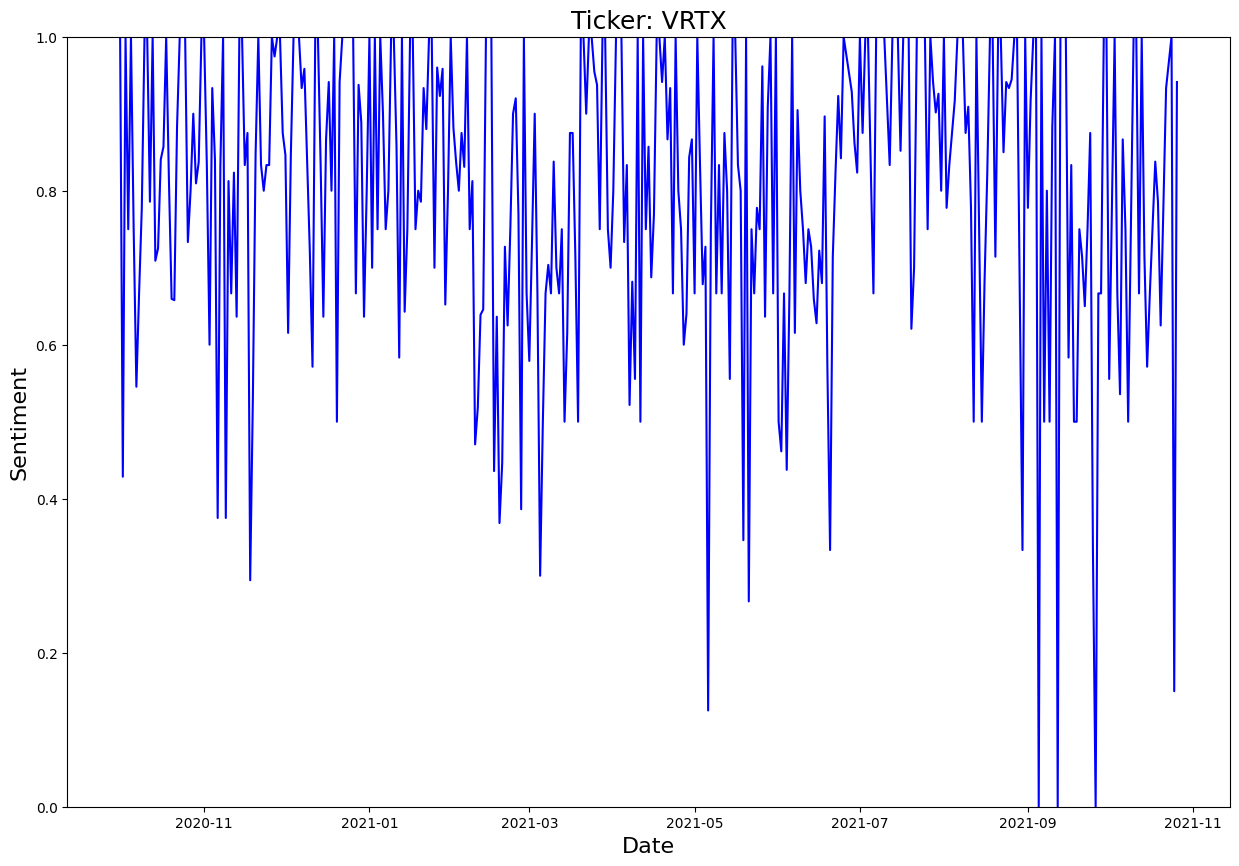

In [60]:
fmt = '%Y-%m-%d'
ticker = 'VRTX'
flag = (df_sent_day['ticker_f'] == ticker)
plt.figure(figsize = (15,10))
plt.plot_date(
    df_sent_day[flag]['created_day'].apply(lambda x: datetime.datetime.strptime(x, fmt)),
    df_sent_day[flag]['label'],
    'b-'
)
plt.xlabel('Date', fontsize = 16)
plt.ylabel('Sentiment', fontsize = 16)
plt.ylim([0,1])
plt.title("Ticker: {}".format(ticker), fontsize = 18)

# Learning Exist??

* short-term performance  
* long-term performance  

Expert?

In [61]:
df_price_roll.head()

,ticker,date,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,up_next7,prc_next16,...,up_next30,prc_next37,ret_next37,up_next37,prc_next44,ret_next44,up_next44,prc_next60,ret_next60,up_next60
0,A,2020-06-29,87.29,88.37,1.012373,1,89.31,1.023141,1,92.88,...,1,97.89,1.121434,1,97.63,1.118456,1,99.90,1.144461,1
1,A,2020-06-30,88.37,88.11,0.997058,0,89.21,1.009505,1,92.86,...,1,97.45,1.102750,1,98.77,1.117687,1,99.90,1.130474,1
2,A,2020-07-01,88.11,88.68,1.006469,1,89.54,1.016230,1,94.37,...,1,97.78,1.109749,1,97.37,1.105096,1,99.90,1.133810,1
3,A,2020-07-02,88.68,88.68,1.000000,0,89.92,1.013983,1,94.37,...,1,97.78,1.102616,1,97.37,1.097993,1,100.42,1.132386,1
4,A,2020-07-03,88.68,88.68,1.000000,0,89.42,1.008345,1,94.37,...,1,97.78,1.102616,1,97.37,1.097993,1,101.12,1.140280,1


In [62]:
df_msg_sent.head()

,id,body,created_at,links,mentioned_users,user.id,user.username,user.name,user.avatar_url,user.avatar_url_ssl,...,structurable.price,structurable.side,structurable.trigger,structurable.brokerage_order_type,structurable.created_at,structurable.share_copy,structurable.type,created_day,label,pred_pos_prob
0,247533715,Latest US Markets Earnings Preannouncements: $...,2020-10-01T15:21:23Z,NaN,[],1550174,Finscreener,Finscreener,https://avatars.stocktwits.com/production/1550...,https://avatars.stocktwits.com/production/1550...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-01,1,0.998218
1,247626645,$A Form S-8 (securities to be offered to emplo...,2020-10-01T20:06:35Z,[{'title': 'S-8 Form - Securities to be offere...,[],2762379,Newsfilter,@newsfilterio,https://avatars.stocktwits.com/production/2762...,https://avatars.stocktwits.com/production/2762...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-01,1,0.994090
2,247626778,$A [15s. delayed] filed form S-8 on October 01...,2020-10-01T20:06:55Z,"[{'title': 'Flash Alert', 'url': 'https://s.fl...",[],595702,fla,FlashAlert_me,https://avatars.stocktwits.com/production/5957...,https://avatars.stocktwits.com/production/5957...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-01,0,0.891912
3,247627289,Securities to be offered to employees in emplo...,2020-10-01T20:08:12Z,"[{'title': 'Conference Call Transcripts', 'url...",[],210967,cctranscripts,Conference Call Transcripts,https://avatars.stocktwits.com/production/2109...,https://avatars.stocktwits.com/production/2109...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-01,0,0.853661
4,247701534,"$A 1 Plate with fried Rice, orange chicken and...",2020-10-02T03:05:01Z,NaN,[],3481209,StreetWaller,Ryan,https://avatars.stocktwits.com/production/3481...,https://avatars.stocktwits.com/production/3481...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-02,0,0.775201


In [63]:
ticker_list = list(set(df_price_roll['ticker'].unique().tolist()) & set(df_msg_sent['ticker_f'].unique().tolist()))

In [64]:
len(ticker_list)

333

In [65]:
df_price_roll['created_day'] = df_price_roll['date'].dt.strftime('%Y-%m-%d') 

In [66]:
day_list = list(set(df_price_roll['created_day'].unique().tolist()) & set(df_msg_sent['created_day'].unique().tolist()))

In [67]:
len(day_list)

391

## Merge

In [68]:
df_msg_sent_price = pd.merge(
    df_msg_sent,
    df_price_roll,
    left_on = ['ticker_f', 'created_day'],
    right_on = ['ticker', 'created_day'],
    how = 'left'
)

In [69]:
df_msg_sent_price = df_msg_sent_price.dropna(subset=['prc'])

In [70]:
df_msg_sent.shape

(3744701, 77)

In [71]:
df_msg_sent_price.shape

(3716974, 104)

In [72]:
ticker = 'BA'
flag = (df_msg_sent_price['ticker'] == ticker)
df_msg_sent_price[flag]

,id,body,created_at,links,mentioned_users,user.id,user.username,user.name,user.avatar_url,user.avatar_url_ssl,...,up_next30,prc_next37,ret_next37,up_next37,prc_next44,ret_next44,up_next44,prc_next60,ret_next60,up_next60
1105999,247405141,$BA for those that watch the 4 hour (which you...,2020-10-01T00:00:52Z,NaN,[],2902789,Sarge_slaughter,Mason,https://avatars.stocktwits.com/production/2902...,https://avatars.stocktwits.com/production/2902...,...,0.0,157.74,0.939712,0.0,187.11,1.114679,1.0,210.71,1.255272,1.0
1106000,247405493,$BA think we might see an open around 173 and ...,2020-10-01T00:02:59Z,NaN,[],2006225,MattMeezy,Matt,https://avatars.stocktwits.com/production/2006...,https://avatars.stocktwits.com/production/2006...,...,0.0,157.74,0.939712,0.0,187.11,1.114679,1.0,210.71,1.255272,1.0
1106001,247406665,$BA Ready for 180 tomorrow,2020-10-01T00:09:52Z,NaN,[],3754904,Andy_Flower,Andy,https://avatars.stocktwits.com/production/3754...,https://avatars.stocktwits.com/production/3754...,...,0.0,157.74,0.939712,0.0,187.11,1.114679,1.0,210.71,1.255272,1.0
1106002,247406704,$BA please don’t bother me for the rest of the...,2020-10-01T00:10:10Z,NaN,[],2241998,Diedrt07,Trent,https://avatars.stocktwits.com/production/2241...,https://avatars.stocktwits.com/production/2241...,...,0.0,157.74,0.939712,0.0,187.11,1.114679,1.0,210.71,1.255272,1.0
1106003,247407057,$BA Steve is upbeat...But no timeline...https:...,2020-10-01T00:12:22Z,"[{'title': ""FAA's Dickson upbeat after flying ...",[],1916993,Terrordome,MJ,https://avatars.stocktwits.com/production/1916...,https://avatars.stocktwits.com/production/1916...,...,0.0,157.74,0.939712,0.0,187.11,1.114679,1.0,210.71,1.255272,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245302,396406568,"$BA \n\nOh boy, if you know… well have a good ...",2021-10-26T23:52:35Z,NaN,[],1826913,AmyJack,Paul Cha,https://avatars.stocktwits.com/production/1826...,https://avatars.stocktwits.com/production/1826...,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1245303,396406812,$BA New Money Here 📣📣📣📣📣🧞‍♂️,2021-10-26T23:53:09Z,NaN,[],1337652,HollywoodWolf777,Wolf Gang,https://avatars.stocktwits.com/production/1337...,https://avatars.stocktwits.com/production/1337...,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1245304,396407160,$BA I am so conditioned to be disappointed by ...,2021-10-26T23:53:54Z,NaN,[],472180,stinaz,Jake,https://avatars.stocktwits.com/production/4721...,https://avatars.stocktwits.com/production/4721...,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
1245305,396409206,$BA 29-Oct-21 ATM Implied Volatility is up +23...,2021-10-26T23:58:43Z,"[{'title': 'Market Chameleon', 'url': 'https:/...",[],800154,marketchameleonwins,marketchameleon,https://avatars.stocktwits.com/production/8001...,https://avatars.stocktwits.com/production/8001...,...,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0


In [73]:
df_msg_sent_price.iloc[0].to_dict()

{'id': 247533715,
 'body': 'Latest US Markets Earnings Preannouncements: $A $AAL $AAN $AAP $AAPL\nSource: Finscreener',
 'created_at': '2020-10-01T15:21:23Z',
 'links': nan,
 'mentioned_users': '[]',
 'user.id': 1550174,
 'user.username': 'Finscreener',
 'user.name': 'Finscreener',
 'user.avatar_url': 'https://avatars.stocktwits.com/production/1550174/thumb-1531918007.png',
 'user.avatar_url_ssl': 'https://avatars.stocktwits.com/production/1550174/thumb-1531918007.png',
 'user.join_date': '2018-07-18',
 'user.official': False,
 'user.identity': 'User',
 'user.classification': '[]',
 'user.followers': 1453,
 'user.following': 28,
 'user.ideas': 11715,
 'user.watchlist_stocks_count': 0,
 'user.like_count': 45,
 'user.plus_tier': nan,
 'user.premium_room': nan,
 'user.trade_app': False,
 'user.portfolio_waitlist': nan,
 'user.portfolio_status': nan,
 'source.id': 2269,
 'source.title': 'StockTwits Web',
 'source.url': 'https://stocktwits.com',
 'entities.sentiment': nan,
 'entities.sentim

## `df_trend`: Trend?

* [Time Series Components](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

In [74]:
len(ticker_list)

333

In [75]:
# window size of performance
window_t = 7

### `panel_price`

In [76]:
df_price_roll.columns

Index(['ticker', 'date', 'prc', 'prc_next1', 'ret_next1', 'up_next1',
       'prc_next7', 'ret_next7', 'up_next7', 'prc_next16', 'ret_next16',
       'up_next16', 'prc_next23', 'ret_next23', 'up_next23', 'prc_next30',
       'ret_next30', 'up_next30', 'prc_next37', 'ret_next37', 'up_next37',
       'prc_next44', 'ret_next44', 'up_next44', 'prc_next60', 'ret_next60',
       'up_next60', 'created_day'],
      dtype='object')

In [77]:
col = ['prc', 'prc_next1', 'ret_next1', 'up_next1',
       'prc_next7', 'ret_next7', 'up_next7', 'prc_next16', 'ret_next16',
       'up_next16', 'prc_next23', 'ret_next23', 'up_next23', 'prc_next30',
       'ret_next30', 'up_next30', 'prc_next37', 'ret_next37', 'up_next37',
       'prc_next44', 'ret_next44', 'up_next44', 'prc_next60', 'ret_next60',
       'up_next60']

In [78]:
panel_price = df_msg_sent_price.groupby(['ticker_f', 'created_day'])[col].mean().reset_index()

In [107]:
# panel_price = df_msg_sent_price.groupby(['ticker_f', 'created_day'])['prc'].mean().reset_index()
# panel_price['prc'].fillna(method = 'ffill', inplace = True)
# for window_t in [1,7,30,60]:
#     panel_price['prc_next{}'.format(window_t)] = panel_price.groupby(['ticker_f'])['prc'].shift(-window_t)
#     panel_price['ret_next{}'.format(window_t)] = panel_price['prc_next{}'.format(window_t)]/panel_price['prc']
#     panel_price['up_next{}'.format(window_t)] = (panel_price['ret_next{}'.format(window_t)] > 1.0).astype(int)

In [108]:
# panel_price['prc_next{}'.format(window_t)] = panel_price.groupby(['ticker_f'])['prc'].shift(-window_t)
# panel_price['ret_next{}'.format(window_t)] = panel_price['prc_next{}'.format(window_t)]/panel_price['prc']
# panel_price['up_next{}'.format(window_t)] = (panel_price['ret_next{}'.format(window_t)] > 1.0).astype(int)

In [66]:
# df_price[
#     (df_price['ticker'] == 'BA') &
#     (df_price['date'] == '2020-10-01')
# ]

In [79]:
for x in [1,7,16,23,30,37,44,60]:
    panel_price[['up_next{}'.format(x)]] = panel_price[['up_next{}'.format(x)]].astype(int)

In [80]:
panel_price.head(10)

,ticker_f,created_day,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,up_next7,prc_next16,...,up_next30,prc_next37,ret_next37,up_next37,prc_next44,ret_next44,up_next44,prc_next60,ret_next60,up_next60
0,A,2020-10-01,101.22,100.01,0.988046,0,104.16,1.029046,1,106.70,...,1,112.54,1.111836,1,110.17,1.088421,1,116.90,1.154910,1
1,A,2020-10-02,100.01,100.01,1.000000,0,105.76,1.057494,1,106.70,...,1,112.54,1.125287,1,110.17,1.101590,1,115.36,1.153485,1
2,A,2020-10-03,100.01,100.01,1.000000,0,105.76,1.057494,1,105.49,...,1,112.50,1.124888,1,110.27,1.102590,1,114.57,1.145585,1
3,A,2020-10-04,100.01,103.12,1.031097,1,105.76,1.057494,1,105.61,...,1,110.20,1.101890,1,109.86,1.098490,1,113.58,1.135686,1
4,A,2020-10-05,103.12,101.63,0.985551,0,105.43,1.022401,1,104.83,...,1,109.41,1.060997,1,105.95,1.027444,1,115.15,1.116660,1
5,A,2020-10-06,101.63,103.88,1.022139,1,105.42,1.037292,1,106.77,...,1,109.44,1.076847,1,108.68,1.069369,1,115.15,1.133032,1
6,A,2020-10-07,103.88,104.16,1.002695,1,105.06,1.011359,1,106.17,...,1,110.17,1.060551,1,110.89,1.067482,1,115.15,1.108491,1
7,A,2020-10-08,104.16,105.76,1.015361,1,105.32,1.011137,1,106.17,...,1,110.17,1.057700,1,110.89,1.064612,1,114.40,1.098310,1
8,A,2020-10-09,105.76,105.76,1.000000,0,106.70,1.008888,1,106.17,...,1,110.17,1.041698,1,110.89,1.048506,1,117.01,1.106373,1
9,A,2020-10-10,105.76,105.76,1.000000,0,106.70,1.008888,1,104.63,...,1,110.27,1.042644,1,112.21,1.060987,1,116.40,1.100605,1


In [81]:
Counter([''.join([str(j) for j in i]) for i in panel_price[[
    'up_next1',
    'up_next7',
    'up_next16',
    'up_next23',
    'up_next30',
    'up_next37',
    'up_next44'
]].values])

Counter({'0111111': 15045,
         '0000000': 14196,
         '1111111': 13657,
         '0011111': 5442,
         '1000000': 4572,
         '0100000': 3660,
         '1100000': 3167,
         '0001111': 2517,
         '1011111': 2284,
         '0000111': 1957,
         '0110000': 1943,
         '1110000': 1599,
         '0111000': 1551,
         '0000011': 1545,
         '0000001': 1512,
         '0101111': 1237,
         '0010000': 1182,
         '0111110': 1155,
         '1111100': 1076,
         '1111000': 1071,
         '0111100': 1063,
         '1101111': 907,
         '1001111': 902,
         '1111110': 872,
         '0011000': 818,
         '0110111': 758,
         '0001000': 757,
         '1110111': 700,
         '0100111': 681,
         '0111011': 671,
         '1000111': 615,
         '0011110': 562,
         '0000010': 524,
         '0000100': 521,
         '0011100': 521,
         '1010000': 519,
         '1000011': 496,
         '0010111': 495,
         '1100111': 492,
 

### `performance`

In [82]:
# flag = (df_msg_sent_price['created_day'] == day)
df_t_u = df_msg_sent_price.groupby(['ticker_f', 'user.id', 'created_day'])['label'].mean().reset_index()

In [83]:
df_perf = pd.merge(
    df_t_u,
    panel_price,
    left_on = ['ticker_f', 'created_day'],
    right_on = ['ticker_f', 'created_day'],
    how= 'left'
)

In [84]:
# window_t = 7
for window_t in [1,7,16,23,30,37,44,60]:
    df_perf['perf_next{}'.format(window_t)] = (
        df_perf['up_next{}'.format(window_t)].astype(int) == (df_perf['label']>0.5).astype(int)
    ).astype(int)

In [85]:
df_perf.shape

(2028259, 37)

In [86]:
df_perf.head()

,ticker_f,user.id,created_day,label,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,...,ret_next60,up_next60,perf_next1,perf_next7,perf_next16,perf_next23,perf_next30,perf_next37,perf_next44,perf_next60
0,A,881,2021-03-28,1.0,125.64,125.42,0.998249,0,127.69,1.016316,...,1.094715,1,0,1,1,1,1,1,1,1
1,A,881,2021-03-31,1.0,127.14,127.69,1.004326,1,129.34,1.017304,...,1.086440,1,1,1,1,1,1,1,1,1
2,A,881,2021-04-09,1.0,131.91,131.91,1.000000,0,134.58,1.020241,...,1.051854,1,0,1,1,1,1,0,1,1
3,A,881,2021-07-30,1.0,153.23,153.23,1.000000,0,155.70,1.016120,...,1.043529,1,0,1,1,1,1,1,1,1
4,A,881,2021-08-10,1.0,156.52,156.52,1.000000,0,160.91,1.028048,...,0.974125,0,0,1,1,1,1,1,1,0


### experience

In [87]:
dt_format = '%Y-%m-%d'
df_perf['t'] = df_perf['created_day'].apply(lambda x: datetime.datetime.strptime(x, dt_format))

In [88]:
# window size of experience
window_r = 30
# for window_r in [30, 60, 90]:
df_exp = df_perf.sort_values('t').set_index('t').groupby(
    ['ticker_f', 'user.id']
).rolling('{}d'.format(window_r))['label'].count().reset_index()
df_exp.rename(columns = {'label': 'cnt_recent{}'.format(window_r)}, inplace = True)
#
# window_t = 7
for window_t in [1,7,16,23,30,37,44,60]:
    if window_t < window_r:
        ###
        tmp = df_perf.sort_values('t').set_index('t').groupby(
            ['ticker_f', 'user.id']
        ).rolling('{}d'.format(window_r))['perf_next{}'.format(window_t)].sum().reset_index()
        tmp.rename(columns = {
            'perf_next{}'.format(window_t): 'true_next{}_recent{}'.format(window_t, window_r)
        }, inplace = True)
        #
        df_exp = pd.merge(
            df_exp,
            tmp,
            left_on = ['ticker_f', 'user.id', 't'],
            right_on = ['ticker_f', 'user.id', 't'],
            how = 'left'
        )
        df_exp['false_next{}_recent{}'.format(window_t, window_r)] = df_exp[
            'cnt_recent{}'.format(window_r)
        ] - df_exp['true_next{}_recent{}'.format(window_t, window_r)] 
########
# window_r = 60
# for window_r in [60, 90]:
#     tmp = df_perf.sort_values('t').set_index('t').groupby(
#         ['ticker_f', 'user.id']
#     ).rolling('{}d'.format(window_r))['label'].count().reset_index()
#     tmp.rename(columns = {'label': 'cnt_recent{}'.format(window_r)}, inplace = True)
#     df_exp = pd.merge(
#         df_exp,
#         tmp,
#         left_on = ['ticker_f', 'user.id', 't'],
#         right_on = ['ticker_f', 'user.id', 't'],
#         how = 'left'
#     )
#     #
#     # window_t = 7
#     for window_t in [1,7,30,60]:
#         if window_t < window_r:
#             ###
#             tmp = df_perf.sort_values('t').set_index('t').groupby(
#                 ['ticker_f', 'user.id']
#             ).rolling('{}d'.format(window_r))['perf_next{}'.format(window_t)].sum().reset_index()
#             tmp.rename(columns = {
#                 'perf_next{}'.format(window_t): 'true_next{}_recent{}'.format(window_t, window_r)
#             }, inplace = True)
#             #
#             df_exp = pd.merge(
#                 df_exp,
#                 tmp,
#                 left_on = ['ticker_f', 'user.id', 't'],
#                 right_on = ['ticker_f', 'user.id', 't'],
#                 how = 'left'
#             )
#             df_exp['false_next{}_recent{}'.format(window_t, window_r)] = df_exp[
#                 'cnt_recent{}'.format(window_r)
#             ] - df_exp['true_next{}_recent{}'.format(window_t, window_r)] 

In [89]:
df_exp['created_day'] = df_exp['t'].dt.strftime(dt_format)
df_exp.drop(['t'], axis = 1, inplace = True)

In [90]:
df_exp.head()

,ticker_f,user.id,cnt_recent30,true_next1_recent30,false_next1_recent30,true_next7_recent30,false_next7_recent30,true_next16_recent30,false_next16_recent30,true_next23_recent30,false_next23_recent30,created_day
0,A,881,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2021-03-28
1,A,881,2.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,0.0,2021-03-31
2,A,881,3.0,1.0,2.0,3.0,0.0,3.0,0.0,3.0,0.0,2021-04-09
3,A,881,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,2021-07-30
4,A,881,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,2021-08-10


In [91]:
df_perf.shape

(2028259, 38)

In [92]:
df_exp.shape

(2028259, 12)

In [93]:
set(df_exp.columns) & set(df_perf.columns)

{'created_day', 'ticker_f', 'user.id'}

In [94]:
df_perf_exp = pd.merge(
    df_perf,
    df_exp,
    left_on = ['ticker_f', 'user.id', 'created_day'],
    right_on = ['ticker_f', 'user.id', 'created_day'],
    how = 'left'
)

In [95]:
df_perf_exp.shape

(2028259, 47)

In [96]:
df_perf_exp.head()

,ticker_f,user.id,created_day,label,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,...,t,cnt_recent30,true_next1_recent30,false_next1_recent30,true_next7_recent30,false_next7_recent30,true_next16_recent30,false_next16_recent30,true_next23_recent30,false_next23_recent30
0,A,881,2021-03-28,1.0,125.64,125.42,0.998249,0,127.69,1.016316,...,2021-03-28,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,A,881,2021-03-31,1.0,127.14,127.69,1.004326,1,129.34,1.017304,...,2021-03-31,2.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,0.0
2,A,881,2021-04-09,1.0,131.91,131.91,1.000000,0,134.58,1.020241,...,2021-04-09,3.0,1.0,2.0,3.0,0.0,3.0,0.0,3.0,0.0
3,A,881,2021-07-30,1.0,153.23,153.23,1.000000,0,155.70,1.016120,...,2021-07-30,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,A,881,2021-08-10,1.0,156.52,156.52,1.000000,0,160.91,1.028048,...,2021-08-10,2.0,0.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0


In [97]:
df_perf_exp.columns

Index(['ticker_f', 'user.id', 'created_day', 'label', 'prc', 'prc_next1',
       'ret_next1', 'up_next1', 'prc_next7', 'ret_next7', 'up_next7',
       'prc_next16', 'ret_next16', 'up_next16', 'prc_next23', 'ret_next23',
       'up_next23', 'prc_next30', 'ret_next30', 'up_next30', 'prc_next37',
       'ret_next37', 'up_next37', 'prc_next44', 'ret_next44', 'up_next44',
       'prc_next60', 'ret_next60', 'up_next60', 'perf_next1', 'perf_next7',
       'perf_next16', 'perf_next23', 'perf_next30', 'perf_next37',
       'perf_next44', 'perf_next60', 't', 'cnt_recent30',
       'true_next1_recent30', 'false_next1_recent30', 'true_next7_recent30',
       'false_next7_recent30', 'true_next16_recent30', 'false_next16_recent30',
       'true_next23_recent30', 'false_next23_recent30'],
      dtype='object')

In [98]:
df_perf_exp.groupby(['ticker_f','user.id'])['created_day'].count().reset_index()['created_day']

0          6
1          1
2          2
3          3
4         12
          ..
452407     1
452408     1
452409     1
452410    38
452411     8
Name: created_day, Length: 452412, dtype: int64

## Saving

In [99]:
# fname = 'financial_data_pivot.csv'
daytag = '20240918'
fname = os.path.join(
    os.getcwd(),
    os.pardir,
    'Output',
    'Performance',
    daytag,
    'df_finbert_perf_exp_{}.csv'.format(daytag)
)
df_perf_exp.to_csv(
    fname,
    encoding = 'utf-8'
)

---  
---  
---

In [130]:
# fname = 'financial_data_pivot.csv'
fname = os.path.join(
    os.getcwd(),
    'Output',
    'Performance',
    'df_finbert_perf_exp_{}.csv'.format('20240815')
)
df_perf_exp = pd.read_csv(
    fname,
    encoding = 'utf-8',
    index_col = 0
)

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [130]:
fmt = "%Y-%m-%d"
df_perf_exp['t'] = df_perf_exp['t'].apply(lambda x: datetime.datetime.strptime(x, fmt))

In [131]:
df_perf_exp.head()

,ticker_f,user.id,created_day,label,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,...,false_next30_recent60,cnt_recent90,true_next1_recent90,false_next1_recent90,true_next7_recent90,false_next7_recent90,true_next30_recent90,false_next30_recent90,true_next60_recent90,false_next60_recent90
0,A,881,2021-03-28,1.0,125.64,125.42,0.998249,0,127.69,1.016316,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,A,881,2021-03-31,1.0,127.14,127.69,1.004326,1,129.34,1.017304,...,0.0,2.0,1.0,1.0,2.0,0.0,2.0,0.0,2.0,0.0
2,A,881,2021-04-09,1.0,131.91,131.91,1.000000,0,134.58,1.020241,...,0.0,3.0,1.0,2.0,3.0,0.0,3.0,0.0,3.0,0.0
3,A,881,2021-07-30,1.0,153.23,153.23,1.000000,0,155.70,1.016120,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,A,881,2021-08-10,1.0,156.52,156.52,1.000000,0,160.91,1.028048,...,0.0,2.0,0.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0


In [135]:
len(df_perf_exp['ticker_f'].unique())

333

In [136]:
len(df_perf_exp['created_day'].unique())

391

## Test

In [132]:
from scipy.stats import pearsonr

In [133]:
window_r = 60
print("Experience Window: {} days...\n".format(window_r))
# window_t = 60
for window_t in [7, 30]:
    print("\nPerformance Window: {} days...".format(window_t))
    x = 'perf_next{}'.format(window_t)
    y = 'true_next{}_recent{}'.format(window_t, window_r)
    flag = (df_perf_exp[[x,y]].isna().sum(axis = 1)==0) 
    sub = df_perf_exp[flag]
    stat, p_value = pearsonr(sub[x],sub[y])
    print("Corr of {} w/ perf.: {:.4f} (p={:.4f})".format('success', stat, p_value))
    ###
    x = 'perf_next{}'.format(window_t)
    y = 'false_next{}_recent{}'.format(window_t, window_r)
    flag = (df_perf_exp[[x,y]].isna().sum(axis = 1)==0) 
    sub = df_perf_exp[flag]
    stat, p_value = pearsonr(sub[x],sub[y])
    print("Corr of {} w/ perf.: {:.4f} (p={:.4f})".format('failure', stat, p_value))
    ###
    x = 'perf_next{}'.format(window_t)
    y = 'cnt_recent{}'.format(window_r)
    flag = (df_perf_exp[[x,y]].isna().sum(axis = 1)==0) 
    sub = df_perf_exp[flag]
    stat, p_value = pearsonr(sub[x],sub[y])
    print("Corr of {} w/ perf.: {:.4f} (p={:.4f})".format('cnt', stat, p_value))

Experience Window: 60 days...


Performance Window: 7 days...
Corr of success w/ perf.: 0.1051 (p=0.0000)
Corr of failure w/ perf.: -0.0917 (p=0.0000)
Corr of cnt w/ perf.: 0.0111 (p=0.0000)

Performance Window: 30 days...
Corr of success w/ perf.: 0.1549 (p=0.0000)
Corr of failure w/ perf.: -0.1509 (p=0.0000)
Corr of cnt w/ perf.: 0.0110 (p=0.0000)


# Fixed Effects Model

- [Fixed Effects in Linear Regression](https://lost-stats.github.io/Model_Estimation/OLS/fixed_effects_in_linear_regression.html)

In [135]:
# pip install linearmodels -i https://pypi.tuna.tsinghua.edu.cn/simple some-package

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 KB 24.4 MB/s eta 0:00:00
  Created wheel for some-package: filename=some_package-0.1-py3-none-any.whl size=1442 sha256=310d298b4d80fe6aeb2301a9a2075e5194ed8525d738957f16c6553bf3f8af1e
  Stored in directory: /home/mw/.cache/pip/wheels/5c/cd/43/c6d6f088fa8adbb0a90b8e8cea7066be87c9cb552cf867cd83
Successfully built some-package
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
# from linearmodels import PanelOLS

In [6]:
# window_t = 7
# window_r = 60
# y = 'perf_next{}'.format(window_t)
# x = 'true_next{}_recent{}'.format(window_t, window_r)
# c = 'cnt_recent{}'.format(window_r)

In [7]:
# data = df_perf_exp.set_index(['ticker_f', 't'])

NameError: name 'df_perf_exp' is not defined

In [139]:
# data.head()

user.id created_day  label     prc  prc_next1  ret_next1  \
ticker_f t                                                                      
A        2021-03-28      881  2021-03-28    1.0  125.64     125.42   0.998249   
         2021-03-31      881  2021-03-31    1.0  127.14     127.69   1.004326   
         2021-04-09      881  2021-04-09    1.0  131.91     131.91   1.000000   
         2021-07-30      881  2021-07-30    1.0  153.23     153.23   1.000000   
         2021-08-10      881  2021-08-10    1.0  156.52     156.52   1.000000   

                     up_next1  prc_next7  ret_next7  up_next7  ...  \
ticker_f t                                                     ...   
A        2021-03-28         0     129.34   1.029449         1  ...   
         2021-03-31         1     131.91   1.037518         1  ...   
         2021-04-09         0     134.58   1.020241         1  ...   
         2021-07-30         0     155.70   1.016120         1  ...   
         2021-08-10         0     160.91   1.028048         1  ...   

                     false_next30_recent60  cnt_recent90  true_next1_recent90  \
ticker_f t                                                                      
A        2021-03-28                    0.0           1.0                  0.0   
         2021-03-31                    0.0           2.0                  1.0   
         2021-04-09                    1.0           3.0                  1.0   
         2021-07-30                    0.0           1.0                  0.0   
         2021-08-10                    0.0           2.0                  0.0   

                     false_next1_recent90  true_next7_recent90  \
ticker_f t                                                       
A        2021-03-28                   1.0                  1.0   
         2021-03-31                   1.0                  2.0   
         2021-04-09                   2.0                  3.0   
         2021-07-30                   1.0                  1.0   
         2021-08-10                   2.0                  2.0   

                     false_next7_recent90  true_next30_recent90  \
ticker_f t                                                        
A        2021-03-28                   0.0                   1.0   
         2021-03-31                   0.0                   2.0   
         2021-04-09                   0.0                   2.0   
         2021-07-30                   0.0                   1.0   
         2021-08-10                   0.0                   2.0   

                     false_next30_recent90  true_next60_recent90  \
ticker_f t                                                         
A        2021-03-28                    0.0                   1.0   
         2021-03-31                    0.0                   2.0   
         2021-04-09                    1.0                   3.0   
         2021-07-30                    0.0                   1.0   
         2021-08-10                    0.0                   1.0   

                     false_next60_recent90  
ticker_f t                                  
A        2021-03-28                    0.0  
         2021-03-31                    0.0  
         2021-04-09                    0.0  
         2021-07-30                    0.0  
         2021-08-10                    1.0  

[5 rows x 41 columns]

In [140]:
# FE = PanelOLS(
#     data[y], 
#     data[[x, c]],
#     entity_effects = True,
#     time_effects = True
# )

In [141]:
# # Result
# result = FE.fit(
#     cov_type = 'clustered',
#     cluster_entity=True,
#     cluster_time=True
# )

In [142]:
# result

Dep. Variable:,perf_next7,R-squared:,0.0649
Estimator:,PanelOLS,R-squared (Between):,0.0154
No. Observations:,2048369,R-squared (Within):,0.0679
Date:,"Sat, Dec 23 2023",R-squared (Overall):,0.0358
Time:,08:37:00,Log-likelihood,-1.341e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,7.107e+04
Entities:,367,P-value,0.0000
Avg Obs:,5581.4,Distribution:,"F(2,2047610)"
Min Obs:,2.0000,,
Max Obs:,1.997e+05,F-statistic (robust):,367.87


In [143]:
# print(result)

                          PanelOLS Estimation Summary                           
Dep. Variable:             perf_next7   R-squared:                        0.0649
Estimator:                   PanelOLS   R-squared (Between):              0.0154
No. Observations:             2048369   R-squared (Within):               0.0679
Date:                Sat, Dec 23 2023   R-squared (Overall):              0.0358
Time:                        08:37:00   Log-likelihood                -1.341e+06
Cov. Estimator:             Clustered                                           
                                        F-statistic:                   7.107e+04
Entities:                         367   P-value                           0.0000
Avg Obs:                       5581.4   Distribution:               F(2,2047610)
Min Obs:                       2.0000                                           
Max Obs:                    1.997e+05   F-statistic (robust):             367.87
                            

# Mixed Effects

- [MIXED EFFECT REGRESSION](https://www.pythonfordatascience.org/mixed-effects-regression-python/)

In [2]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

In [ ]:
# help(smf.mixedlm)

In [3]:
# window_t = 7
# window_r = 60
# y = 'perf_next{}'.format(window_t)
# x = 'true_next{}_recent{}'.format(window_t, window_r)

In [4]:
# # mixed effects
# df_perf_exp['userid'] = df_perf_exp['user.id'].astype(int).astype(str)
# vc = {'user': '0 + C(userid)', 'time': '0 + C(created_day)'}
# md = smf.mixedlm('{} ~ {}'.format(y,x), 
#                      vc_formula=vc,                                   
#                      re_formula='1', 
#                      groups='ticker_f', 
#                      data=df_perf_exp
#                     )
# mdf = md.fit()
# print(mdf.summary())

NameError: name 'df_perf_exp' is not defined